In [186]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score,confusion_matrix,roc_curve,auc

from math import exp


import itertools
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [36]:
# Load the data
house = pd.read_csv('./housing.csv')

In [37]:
# A:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [38]:
# A:
house.shape

(1460, 81)

### Look for null values in each columns

In [39]:
house.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [40]:
len(house['FireplaceQu'][house['Fireplaces']==0])

690

In [41]:
len(house['PoolQC'][house['PoolArea']==0])

1453

- Above two code shows that when there is NULL values in categorical variables it reprents the absence of that category.
  That's why converting categorical NULLs to 'NA'.
- All the Numerical NULLS will be filled with 0s. 

In [42]:
house.fillna({
    'LotFrontage' : 0.0,
    'Alley'       : 'NA',
    'FireplaceQu' : 'NA',
    'GarageType'  : 'NA',
    'GarageYrBlt' : 0.0,
    'GarageFinish': 'NA',
    'GarageQual'  : 'NA',
    'GarageCond'  : 'NA',
    'PoolQC'      : 'NA',
    'Fence'       : 'NA',
    'MiscFeature' : 'NA',
    'MasVnrArea'  :  0.0,
    'MasVnrType'  : 'None',
    'BsmtCond'    : 'NA',
    'BsmtExposure': 'NA',
    'BsmtFinType1': 'NA',
    'BsmtFinType2': 'NA'
     },inplace=True);

In [43]:
# Checking presence of nulls after executing above code
house.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
                ..
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
PoolQC      

In [44]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [45]:
#Creating a copy of original data frame so that Original won't get affected
house_new = house.copy()

### Drop all the houses that are non-residential

In [46]:
house_new.drop(house_new[(house_new['SaleCondition']=='Partial') |
                         ((house_new['OverallQual'] == 1) | (house_new['OverallQual'] == 2))|
                         ((house_new['OverallCond'] == 1) | (house_new['OverallCond'] == 2)) |
                         (house_new['Functional'] == 'Sev') |
                         (house_new['MSZoning'] == 'C (all)')].index,inplace=True)
house_new.shape ,house.shape

((1317, 81), (1460, 81))

#### Identifying the fixed features from the dataset

In [47]:
fixed_feature_cols = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley', 'LotShape', 'LandContour','LotConfig',
                      'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType','HouseStyle','YearBuilt', 'YearRemodAdd',
                      'MasVnrArea', 'Foundation','BsmtQual','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF', '2ndFlrSF',
                      'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath','HalfBath', 'BedroomAbvGr', 
                      'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', 'GarageType','GarageYrBlt', 'GarageCars', 'GarageArea',
                      'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea','MoSold', 'YrSold']


In [48]:
house_fixed_feature = house_new[fixed_feature_cols]
house_fixed_feature.shape

(1317, 47)

#### Drop BsmtFinSF1 and BsmtFinSF2 as we already have total basement surface TotalBsmtSF

In [49]:
house_fixed_feature.drop(['BsmtFinSF1','BsmtFinSF2'],axis=1,inplace=True)
house_fixed_feature.shape

(1317, 45)

#### Count total basement bathroom and drop all full and Half basement bathrooms

In [50]:
house_fixed_feature['TotalBsmtBath'] = house_fixed_feature['BsmtFullBath'] + house_fixed_feature['BsmtHalfBath'] * 0.5
house_fixed_feature.drop(['BsmtFullBath','BsmtHalfBath'],axis=1,inplace=True)
house_fixed_feature.shape

(1317, 44)

#### Count total above ground bathroom and Drop all full and Half above ground bathrooms

In [51]:
house_fixed_feature['TotalBath'] = house_fixed_feature['FullBath'] + house_fixed_feature['HalfBath'] * 0.5
house_fixed_feature.drop(['FullBath','HalfBath'],axis=1,inplace=True)
house_fixed_feature.shape

(1317, 43)

#### Count TotalporchSurface by adding OpenPorchSf, EnclosedPorch, 3SsnPorch and ScreenPorch. 

In [52]:
house_fixed_feature['TotalPorchSF'] = house_fixed_feature['OpenPorchSF'] + house_fixed_feature['EnclosedPorch'] \
                                    + house_fixed_feature['3SsnPorch'] + house_fixed_feature['ScreenPorch']
house_fixed_feature.drop(['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'],axis=1,inplace=True)
house_fixed_feature.shape

(1317, 40)

#### Find the low variance columns in fixed features 

In [53]:
low_var_cols = []
for col in house_fixed_feature.columns:
    if np.max(house_fixed_feature[col].value_counts(normalize=True)) > 0.99:
        low_var_cols.append(col)
low_var_cols

['Street', 'Condition2', 'PoolArea']

#### Delete these low variance columns

In [54]:
house_fixed_feature.drop(['Street', 'Condition2', 'PoolArea'],axis=1,inplace=True)
house_fixed_feature.shape

(1317, 37)

#### Devide the data frame into numerical fixed features and categorical fixed features

In [55]:
fixed_feature_numerical_cols = [col for col in house_fixed_feature.columns if not (house_fixed_feature[col].dtype == np.object)]
len(fixed_feature_numerical_cols)

24

In [56]:
house_fixed_numerical_df = house_fixed_feature[fixed_feature_numerical_cols]
house_fixed_numerical_df.shape

(1317, 24)

#### Look at the crrelation heatmap of these numerical fixed features

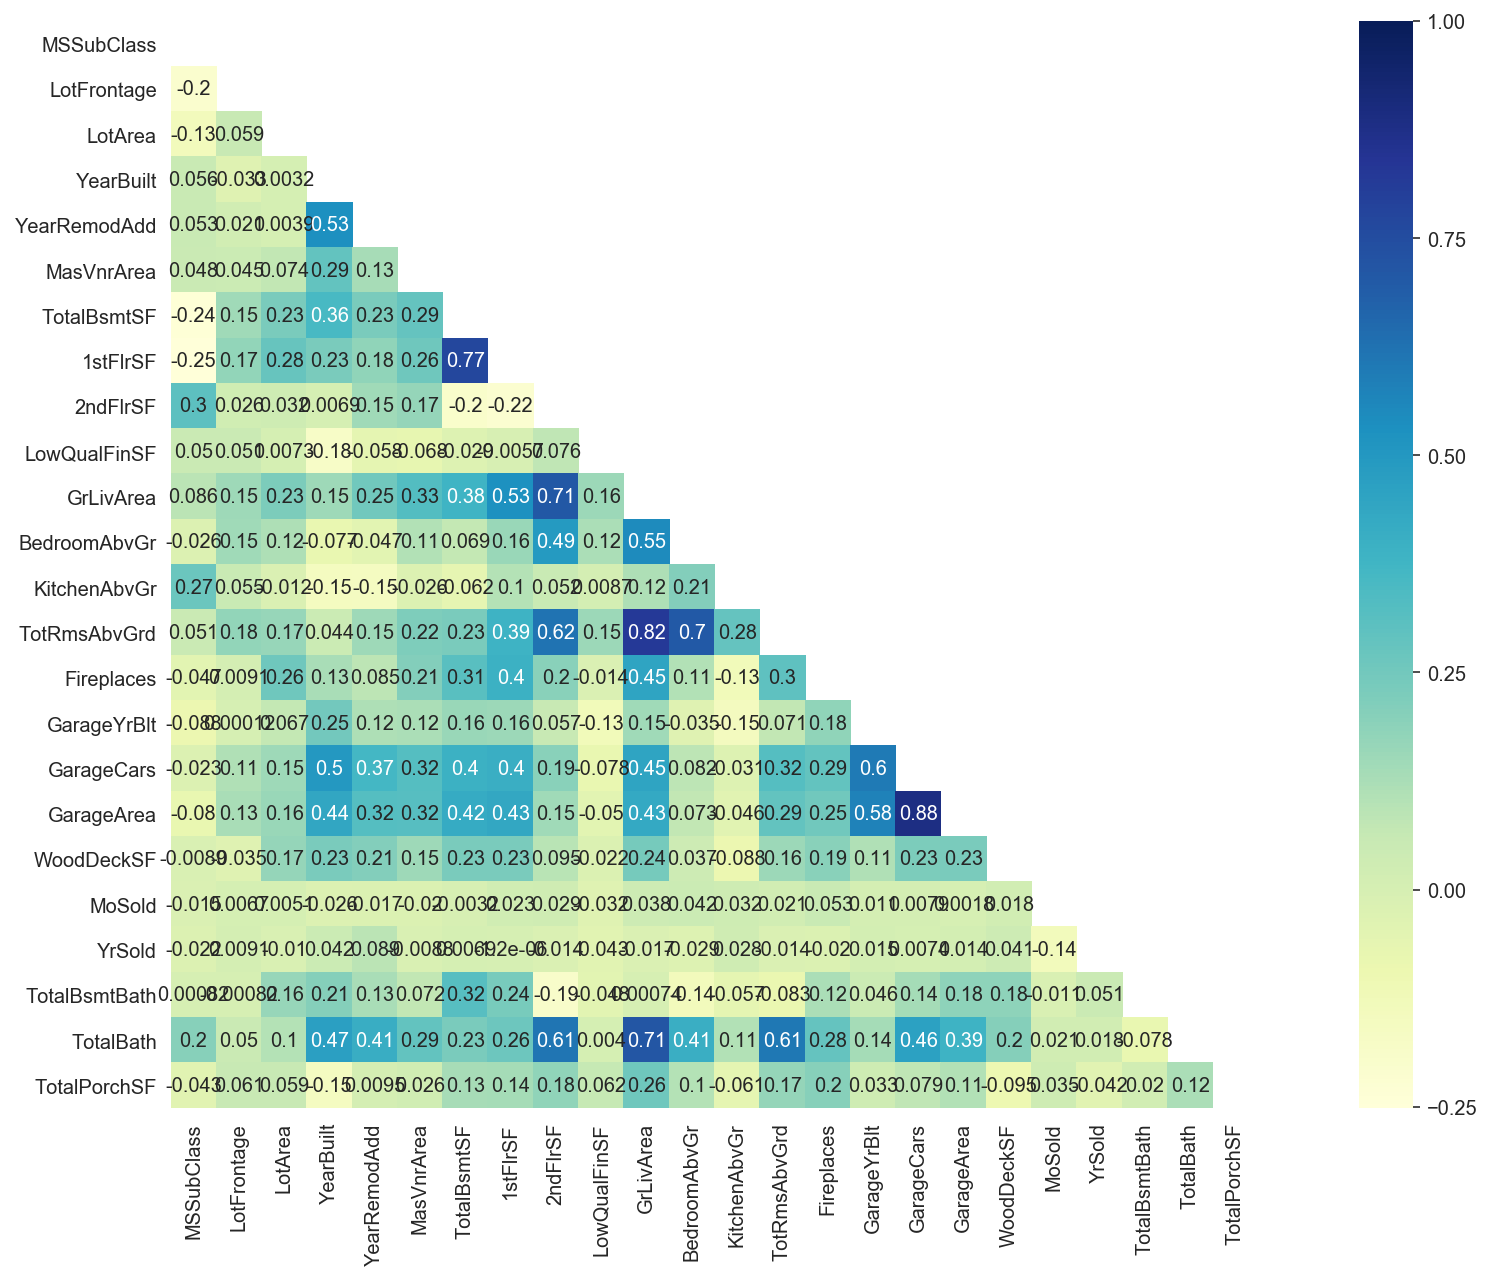

In [57]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
corr = house_fixed_numerical_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, square=True, annot=True,cmap="YlGnBu")

- Here GarageArea is highly correlated with GarageCars So we will drop GarageCars
- GrLivingArea is highly correlated with TotRmsAbVGrd so we wiil drop TotRmsAbVGrd
- 1stFlrSF is highly correkated with TotalBasementSf so we will drop 1stFlrSF
- 2ndFlrSF is highly correlated with GrLivAres so we will drop 2ndFlrSF
- TotRmsAbvGrd is highly correlated with BedroomAbvGrd so we will drop BedroomAbvGrd

In [58]:
house_fixed_numerical_df.drop(['GarageCars','TotRmsAbvGrd','1stFlrSF','2ndFlrSF','BedroomAbvGr'],axis=1,inplace=True)
house_fixed_numerical_df.shape

(1317, 19)

#### Create a data frame with categorical fixed features

In [59]:
fixed_feature_categorical_cols = [col for col in house_fixed_feature.columns if (house_fixed_feature[col].dtype == np.object)] 
len(fixed_feature_categorical_cols)


13

In [60]:
house_fixed_categorical_df = house_fixed_feature[fixed_feature_categorical_cols]
house_fixed_categorical_df.shape

(1317, 13)

#### Look at the correlation heatmap of categorical fixed features and remove the highyly correlated features

In [61]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

cols = house_fixed_categorical_df.columns
corrM = np.zeros((len(cols),len(cols)))
corrM.shape
# there's probably a nice pandas way to do this
for idx1,col1 in enumerate(cols):
    for idx2,col2 in enumerate(cols):
        corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(house_fixed_categorical_df[col1], house_fixed_categorical_df[col2]))
        corrM[idx2, idx1] = corrM[idx1, idx2]
corrM;





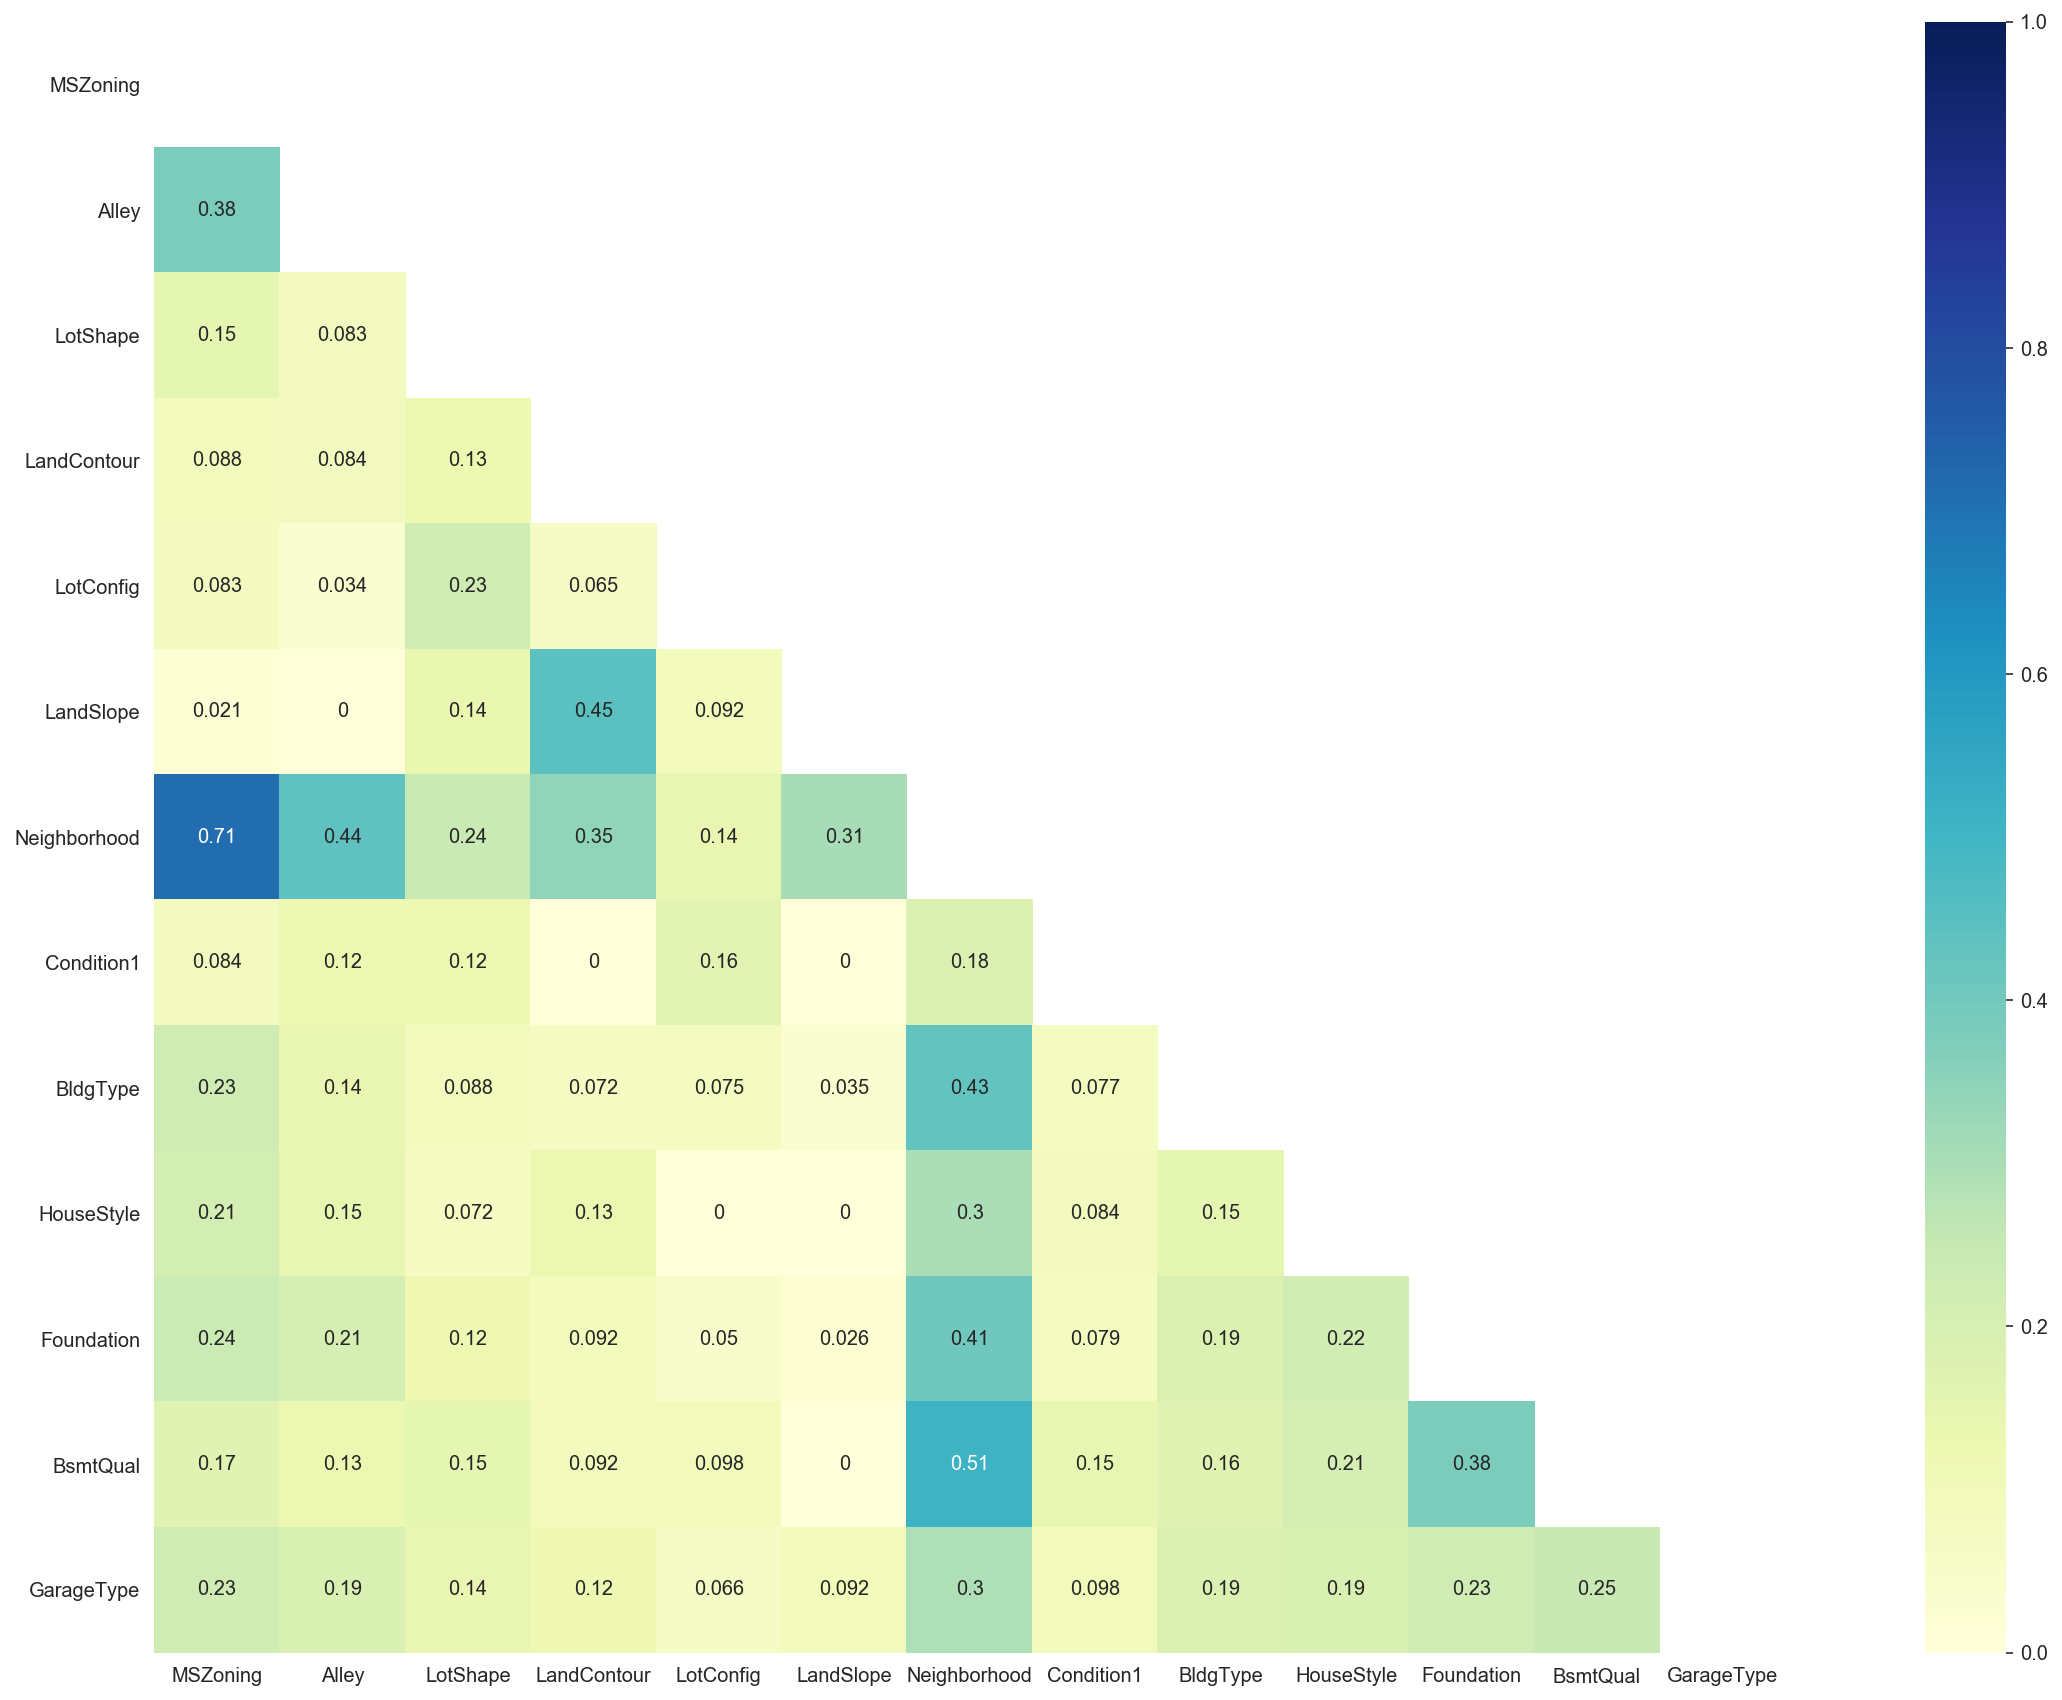

In [62]:
fig = plt.figure(figsize=(25,15))
ax = fig.gca()
corr = pd.DataFrame(corrM, index=cols, columns=cols)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, square=True, annot=True,cmap="YlGnBu")

- MSZoning is highly correlated with neighbourhood so we will drop Neighbourhood
   

In [63]:
house_fixed_categorical_df.drop(['Neighborhood'],axis=1,inplace=True)
house_fixed_categorical_df.shape

(1317, 12)

#### One hot encoding of categorical fixed features

In [64]:
house_fixed_categorical_df = pd.get_dummies(house_fixed_categorical_df,prefix=house_fixed_categorical_df.columns, \
                                            prefix_sep='_',drop_first=True)
house_fixed_categorical_df.shape

(1317, 50)

#### Remove the categorical fixed fetures having low variance after dummy encoding

In [65]:
low_var_columns = []
for col in house_fixed_categorical_df.columns:
    if np.max(house_fixed_categorical_df[col].value_counts(normalize=True)) > 0.99:
        low_var_columns.append(col)
low_var_columns

['LotShape_IR3',
 'LotConfig_FR3',
 'LandSlope_Sev',
 'Condition1_PosA',
 'Condition1_RRAe',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'Foundation_Stone',
 'Foundation_Wood',
 'GarageType_CarPort']

Drop these low variance columns

In [66]:
house_fixed_categorical_df.drop(low_var_columns,axis=1,inplace=True)
house_fixed_categorical_df.shape

(1317, 38)

#### Remove the highly correlated dummy categorical fixed features

In [67]:
corr_matrix_fixed_features = house_fixed_categorical_df.corr().abs()
corr_matrix_fixed_features

# Select upper triangle of correlation matrix
upper = corr_matrix_fixed_features.where(np.triu(np.ones(corr_matrix_fixed_features.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.70)]
to_drop

['MSZoning_RM', 'Foundation_PConc', 'BsmtQual_TA', 'GarageType_Detchd']

Drop the columns having high correlation after dummy coding

In [68]:
house_fixed_categorical_df.drop(to_drop,axis=1,inplace=True)
house_fixed_categorical_df.shape

(1317, 34)

#### Concate the numerical and categorical fixed fetuares 

In [69]:
house_final_fixed_df = pd.concat([house_fixed_categorical_df,house_fixed_numerical_df],axis=1)
house_final_fixed_df.shape

(1317, 53)

#### Create the test-train split based on 'YrSold' and then standerdize the Predictors

In [70]:
X_train_final_fixed = house_final_fixed_df[house_final_fixed_df['YrSold']<2010]
X_train_final_fixed.shape

(1153, 53)

In [71]:
X_test_final_fixed = house_final_fixed_df[house_final_fixed_df['YrSold']>=2010]
X_test_final_fixed.shape

(164, 53)

In [72]:
y_train_fixed = house_new['SalePrice'][house_new['YrSold']<2010]
y_train_fixed.shape


(1153,)

In [73]:
y_test_fixed = house_new['SalePrice'][house_new['YrSold']>=2010]
y_test_fixed.shape

(164,)

In [74]:
ss = StandardScaler()
X_train_final_fixed = ss.fit_transform(X_train_final_fixed)
X_test_final_fixed = ss.fit_transform(X_test_final_fixed)

#### Simple Liner Regression with Train and Test data

In [75]:
lr_fixed = LinearRegression()
lr_fixed.fit(X_train_final_fixed,y_train_fixed)
lr_fixed.score(X_train_final_fixed,y_train_fixed)

0.8418909320943856

In [76]:
lr_fixed.score(X_test_final_fixed,y_test_fixed)

0.8649229563270939

In [77]:
X_train_final_fixed = pd.DataFrame(X_train_final_fixed,columns=house_final_fixed_df.columns)

In [78]:
X_test_final_fixed = pd.DataFrame(X_test_final_fixed,columns=house_final_fixed_df.columns)

#### Lasso linear Regression with cross validation to get the optimum Features

In [79]:
lscv_fixed = LassoCV(cv=8)



lscv_fixed.fit(X_train_final_fixed, y_train_fixed)
lasso_final_fixed_features = X_train_final_fixed.columns[lscv_fixed.coef_>0]
print(len(lasso_final_fixed_features))
lasso_final_fixed_features


25


Index(['MSZoning_RL', 'Alley_NA', 'LotShape_IR2', 'LandContour_HLS',
       'LandContour_Low', 'LotConfig_CulDSac', 'LandSlope_Mod',
       'Condition1_Norm', 'HouseStyle_1.5Unf', 'HouseStyle_SFoyer',
       'Foundation_Slab', 'GarageType_BuiltIn', 'GarageType_NA', 'LotFrontage',
       'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF',
       'GrLivArea', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'TotalBsmtBath',
       'TotalPorchSF'],
      dtype='object')

#### Best Alpha value in cross validation

In [80]:
lscv_fixed.alpha_

563.4337920969008

In [81]:
lscv_fixed.score(X_train_final_fixed,y_train_fixed)

0.8389481232420338

In [82]:
lscv_fixed.score(X_test_final_fixed,y_test_fixed)

0.865041435603797

- Though LassoCV very slightly improve Score but it reduces the features to 25

In [83]:
positive_coefs = []
for coef in lscv_fixed.coef_:
    if coef > 0:
        positive_coefs.append(coef)
positive_coefs
lasso_coefs  = {
                     'column' : lasso_final_fixed_features,
                     'coefs'  : positive_coefs
                }
coef_sorted_df = pd.DataFrame(lasso_coefs,index=lasso_coefs['column'])
coef_sorted_df.drop(['column'],axis=1,inplace=True)
coef_sorted_df.sort_values('coefs',ascending=False)

,coefs
GrLivArea,34447.150573
TotalBsmtSF,13467.041036
YearBuilt,10276.850146
YearRemodAdd,8256.150697
GarageArea,6900.382992
Fireplaces,5656.241510
MasVnrArea,5505.647063
TotalBsmtBath,5322.066527
LotArea,3560.262332
Condition1_Norm,2974.018501


Text(0.5, 1.0, 'Actual Vs Predicted Sales Price')

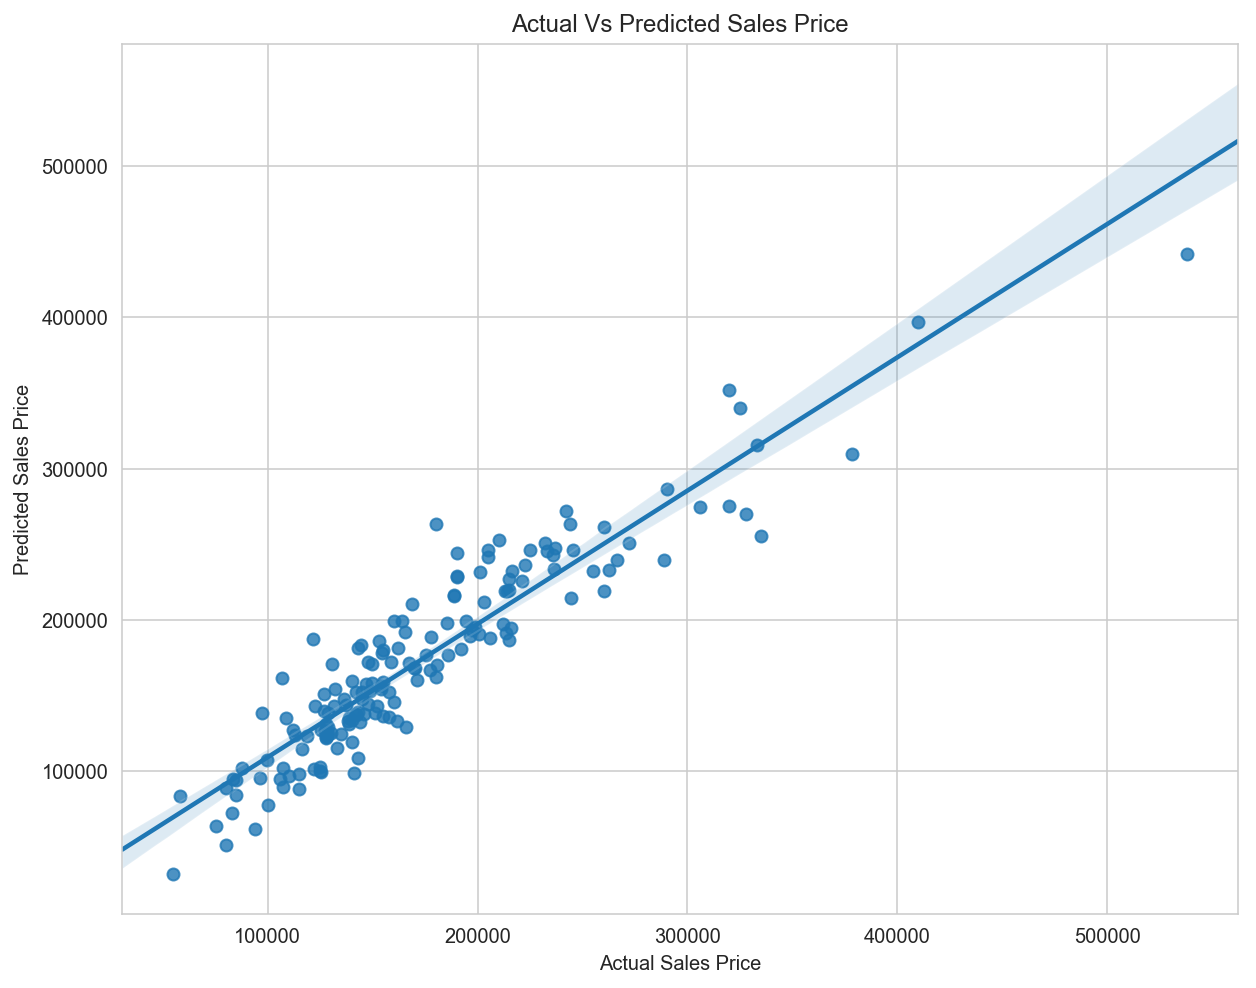

In [84]:
actual_vs_predicted_sales_price_df = pd.DataFrame()
actual_vs_predicted_sales_price_df['Actual Sales Price'] = y_test_fixed
actual_vs_predicted_sales_price_df['Predicted Sales Price'] = lscv_fixed.predict(X_test_final_fixed)
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
ax = sns.regplot(x='Actual Sales Price', y='Predicted Sales Price', data = actual_vs_predicted_sales_price_df,ax=ax)
ax.set_title("Actual Vs Predicted Sales Price")

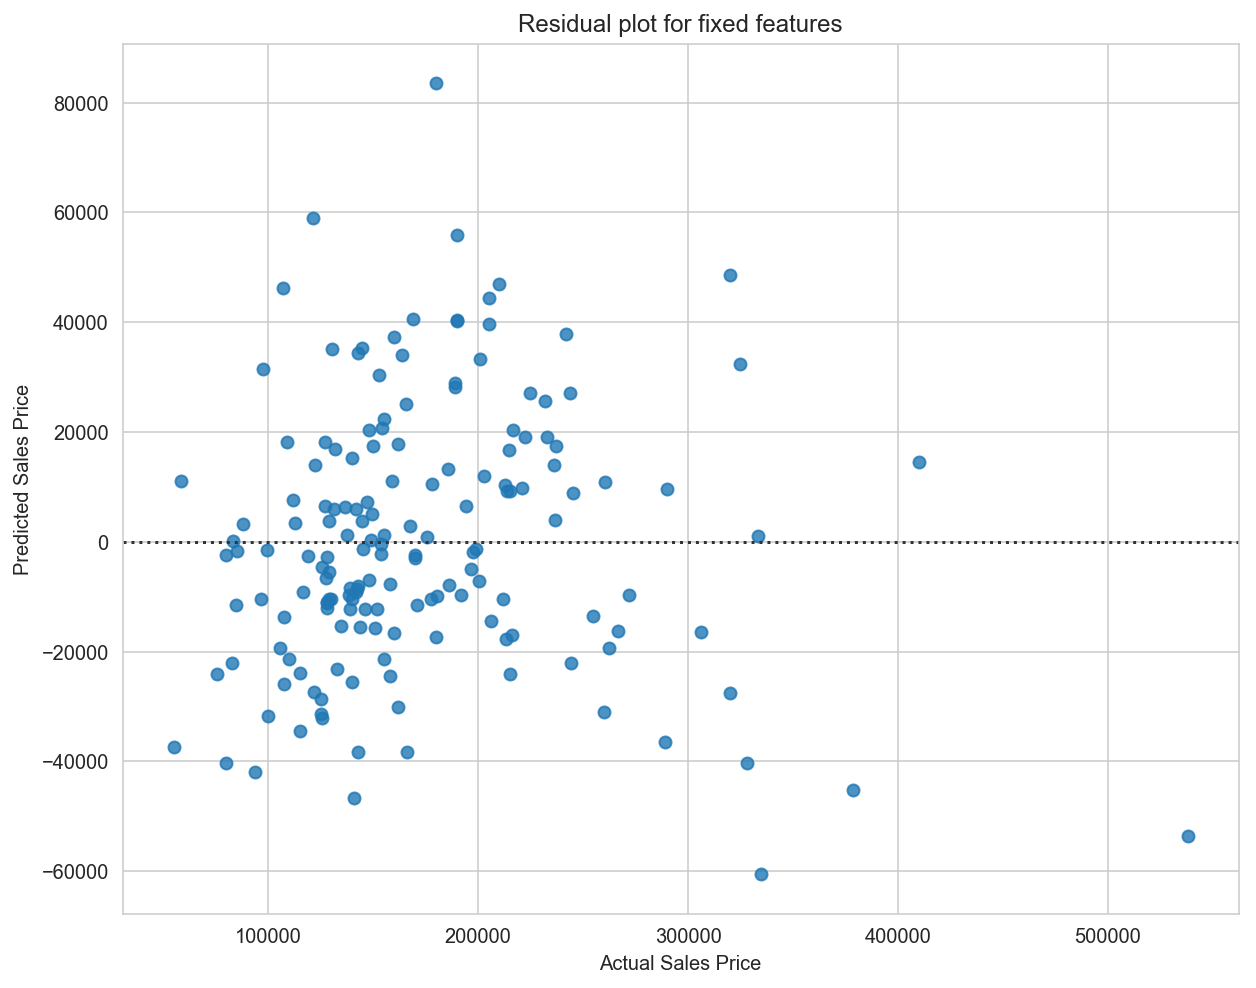

In [85]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
ax.set_title("Residual plot for fixed features");
sns.residplot(x= 'Actual Sales Price', y='Predicted Sales Price', data=actual_vs_predicted_sales_price_df,ax=ax);

In [86]:
train_fixed_pred = lscv_fixed.predict(X_train_final_fixed)
train_fixed_residuals = abs(y_train_fixed - train_fixed_pred)
train_fixed_residuals_actaul = y_train_fixed - train_fixed_pred # for comparision with 2nd model residuals

In [87]:
test_fixed_pred = lscv_fixed.predict(X_test_final_fixed)
test_fixed_residuals = abs(y_test_fixed - test_fixed_pred)
test_fixed_residuals_actaul = y_test_fixed - test_fixed_pred # for comparision with 2nd model residuals

In [287]:
X_train_final_lasso_final = house_final_fixed_df[lasso_final_fixed_features][house_final_fixed_df['YrSold']<2010]
X_train_final_lasso_final.shape

(1153, 25)

In [288]:
X_test_final_lasso_final = house_final_fixed_df[lasso_final_fixed_features][house_final_fixed_df['YrSold']>=2010]
X_test_final_lasso_final.shape

(164, 25)

In [289]:
y_train_fixed_lasso = house_new['SalePrice'][house_new['YrSold']<2010]
y_train_fixed_lasso.shape

(1153,)

In [290]:
y_test_fixed_lasso = house_new['SalePrice'][house_new['YrSold']>=2010]
y_test_fixed_lasso.shape

(164,)

In [352]:
lscv_fixed_final = LassoCV(cv=8)



lscv_fixed_final.fit(X_train_final_lasso_final, y_train_fixed_lasso)
lasso_final_fixed_features_sel = X_train_final_lasso_final.columns[lscv_fixed_final.coef_>0]
print(len(lasso_final_fixed_features_sel))
lasso_final_fixed_features_sel

8


Index(['LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF',
       'GrLivArea', 'GarageArea', 'WoodDeckSF'],
      dtype='object')

In [353]:
lscv_fixed_final.score(X_train_final_lasso_final,y_train_fixed_lasso)

0.7668278276149294

In [354]:
lscv_fixed_final.score(X_test_final_lasso_final,y_test_fixed_lasso)

0.7981501084555801

In [298]:
len(house_new['LotArea'][house_new['LotArea']>4000] & house_new['SalePrice']>200000)

1317

In [305]:
house_new['SalePrice'][house_new['LotArea'] > 50000]

53      385000
249     277000
313     375000
335     228950
384     240000
451     280000
457     256000
706     302000
769     538000
1396    160000
Name: SalePrice, dtype: int64

In [339]:
# out_liers_cols = []
# out_lier_len = []
# for col in house_fixed_numerical_df.columns:
    
#     Q1 = house_fixed_numerical_df[col].quantile(0.25)
#     Q3 = house_fixed_numerical_df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - (IQR * 1.5)
#     upper_bound = Q3 + (IQR * 1.5)
#     out_liers_cols.append(col)
#     out_lier_len.append(len(house_fixed_numerical_df[(house_fixed_numerical_df[col] < lower_bound) | (house_fixed_numerical_df[col] > upper_bound)]))
 

#out_liers_cols, out_lier_len
Q1 = house_fixed_numerical_df['MSSubClass'].quantile(0.25)
Q3 = house_fixed_numerical_df['MSSubClass'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (IQR * 1.5)
upper_bound = Q3 + (IQR * 1.5)

len(house_fixed_numerical_df.drop(house_fixed_numerical_df[(house_fixed_numerical_df['MSSubClass'] < lower_bound) |  (house_fixed_numerical_df['MSSubClass'] > upper_bound)].index))

1220

In [347]:
len(house_fixed_numerical_df[(house_fixed_numerical_df['MSSubClass'] < lower_bound) |  (house_fixed_numerical_df['MSSubClass'] > upper_bound)])

97

In [351]:
house_fixed_numerical_df.drop(house_fixed_numerical_df[(house_fixed_numerical_df['MSSubClass'] < lower_bound) |  (house_fixed_numerical_df['MSSubClass'] > upper_bound)].index)

,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,LowQualFinSF,GrLivArea,KitchenAbvGr,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,MoSold,YrSold,TotalBsmtBath,TotalBath,TotalPorchSF
0,60,65.0,8450,2003,2003,196.0,856,0,1710,1,0,2003.0,548,0,2,2008,1.0,2.5,61
1,20,80.0,9600,1976,1976,0.0,1262,0,1262,1,1,1976.0,460,298,5,2007,0.5,2.0,0
2,60,68.0,11250,2001,2002,162.0,920,0,1786,1,1,2001.0,608,0,9,2008,1.0,2.5,42
3,70,60.0,9550,1915,1970,0.0,756,0,1717,1,1,1998.0,642,0,2,2006,1.0,1.0,307
4,60,84.0,14260,2000,2000,350.0,1145,0,2198,1,1,2000.0,836,192,12,2008,1.0,2.5,84
5,50,85.0,14115,1993,1995,0.0,796,0,1362,1,0,1993.0,480,40,10,2009,1.0,1.5,350
6,20,75.0,10084,2004,2005,186.0,1686,0,1694,1,1,2004.0,636,255,8,2007,1.0,2.0,57
7,60,0.0,10382,1973,1973,240.0,1107,0,2090,1,2,1973.0,484,235,11,2009,1.0,2.5,432
8,50,51.0,6120,1931,1950,0.0,952,0,1774,2,2,1931.0,468,90,4,2008,0.0,2.0,205
10,20,70.0,11200,1965,1965,0.0,1040,0,1040,1,0,1965.0,384,0,2,2008,1.0,1.0,0


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

#### Creating a list of non-fixed features

In [88]:
non_fixed_cols = ['Utilities','OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType',
 'ExterQual','ExterCond','BsmtCond','BsmtExposure','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional',
 'FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','MiscVal'] 
len(non_fixed_cols)

27

In [89]:
house_non_fixed_feature = house_new[non_fixed_cols]
house_non_fixed_feature.shape

(1317, 27)

Reference:-
https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/
https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features

#### Remove the low variance columns from non-fixed features

In [90]:
low_var_columns = []
for col in house_non_fixed_feature.columns:
    if np.max(house_non_fixed_feature[col].value_counts(normalize=True)) > 0.99:
        low_var_columns.append(col)
low_var_columns

['Utilities', 'PoolQC']

- Drop above two columns because it has vary low variance

In [91]:
house_non_fixed_feature.drop(low_var_columns,axis=1,inplace=True)
house_non_fixed_feature.shape

(1317, 25)

#### Devide the non-fixed features into numerical and categorical non-fixed features

In [92]:
non_fixed_feature_numerical_cols = [col for col in house_non_fixed_feature.columns if not (house_non_fixed_feature[col].dtype == np.object)]
len(non_fixed_feature_numerical_cols)

3

In [93]:
house_non_fixed_numerical_feature_df = house_new[non_fixed_feature_numerical_cols]
house_non_fixed_numerical_feature_df.shape

(1317, 3)

#### Create a correlation heatmap of numeric non-fixed features to see highly correlated features

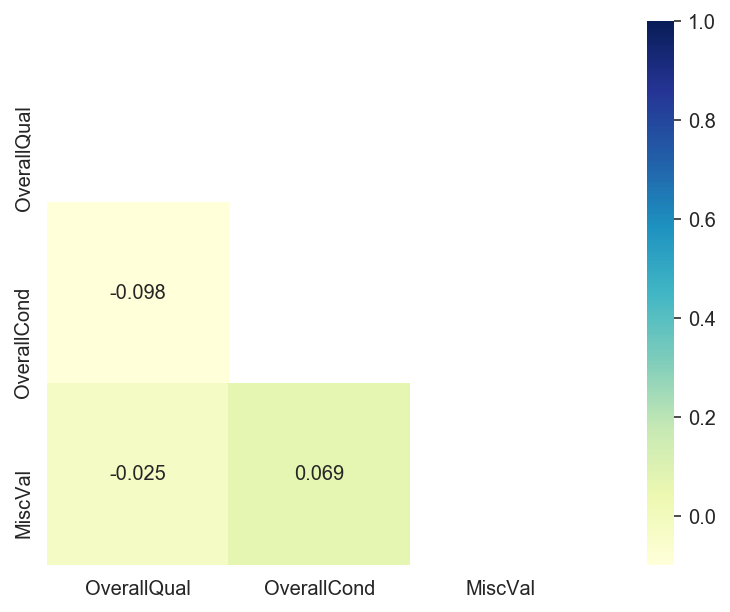

In [94]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
corr = house_non_fixed_numerical_feature_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, square=True, annot=True,cmap="YlGnBu")

- Here no numerical non-fixed features is highly correlated so we won't drop any.

#### Create a data frame of non-fixed categorical features

In [95]:

non_fixed_categorical_cols = [col for col in house_non_fixed_feature.columns if  (house_non_fixed_feature[col].dtype == np.object)]

len(non_fixed_categorical_cols)

22

In [96]:
house_non_fixed_categorical_feature_df = house_new[non_fixed_categorical_cols]
house_non_fixed_categorical_feature_df.shape

(1317, 22)

#### See the correlation heatmap of categorical non-fixed features te see highly correlated features

In [97]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

cols = house_non_fixed_categorical_feature_df.columns
corrM = np.zeros((len(cols),len(cols)))
corrM.shape

for idx1,col1 in enumerate(cols):
    for idx2,col2 in enumerate(cols):
        corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(house_non_fixed_categorical_feature_df[col1], house_non_fixed_categorical_feature_df[col2]))
        corrM[idx2, idx1] = corrM[idx1, idx2]
corrM;

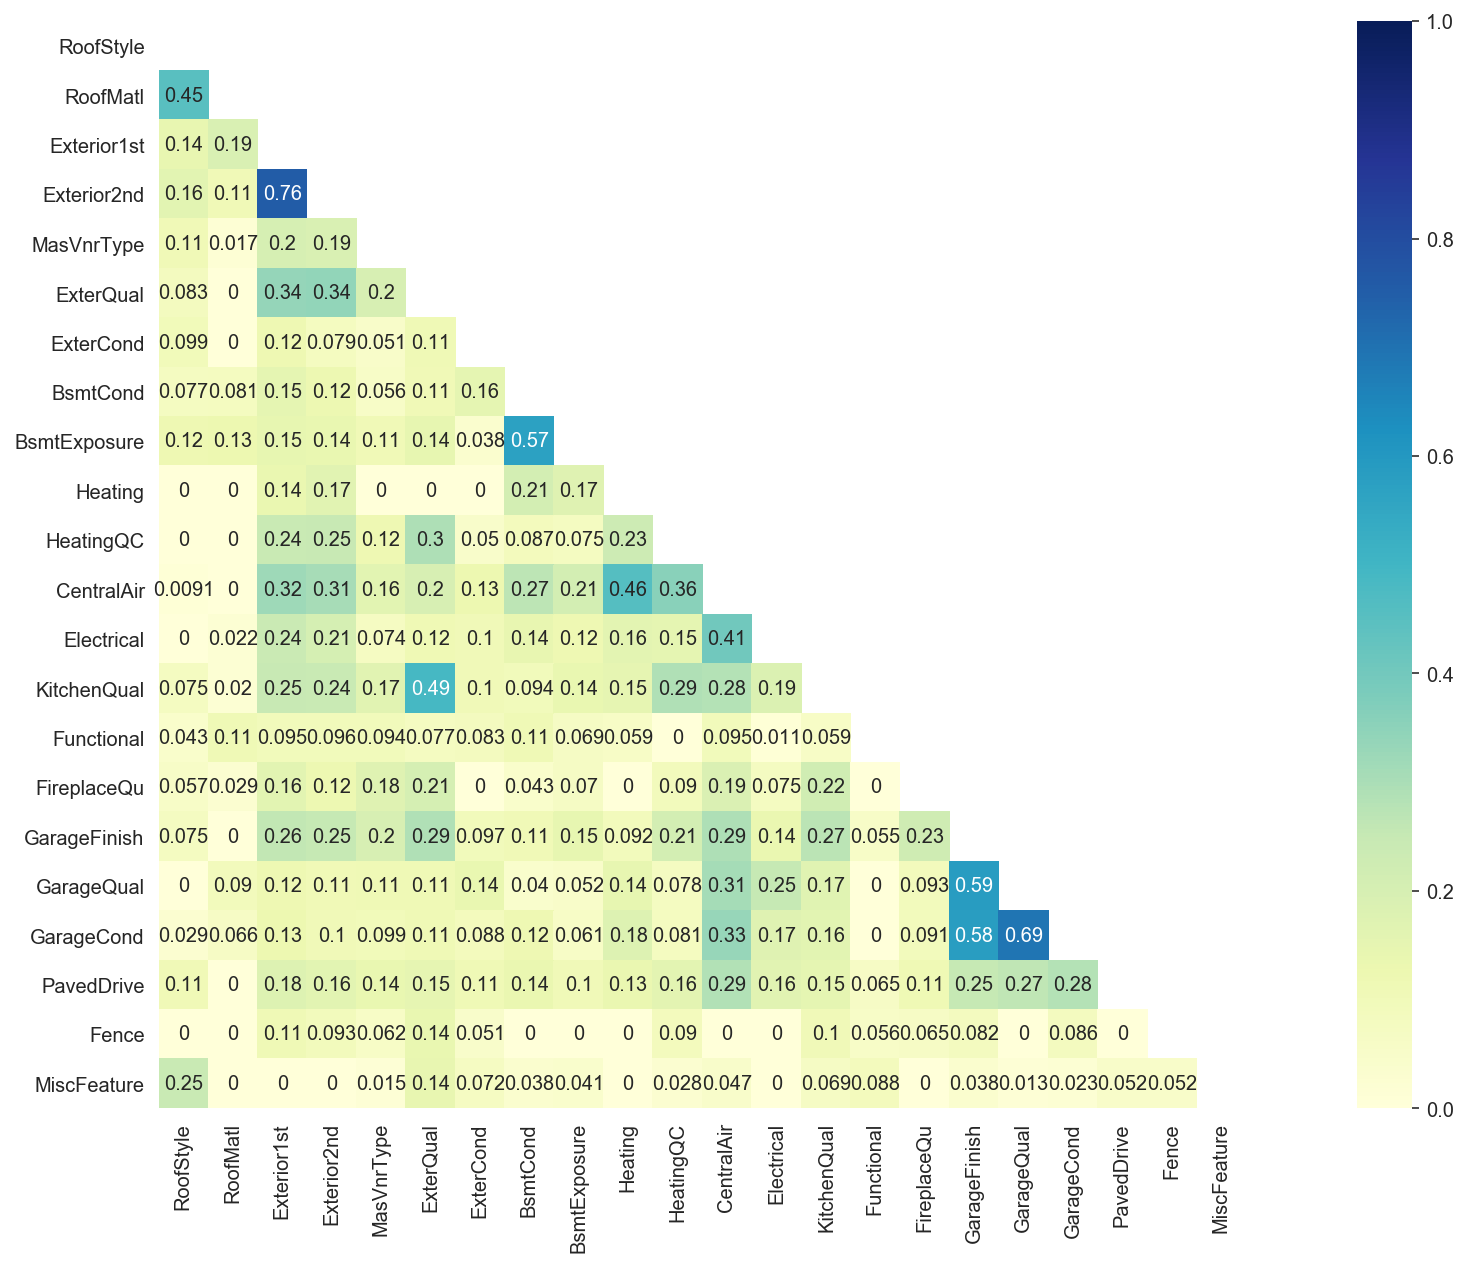

In [100]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
corr = pd.DataFrame(corrM, index=cols, columns=cols)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, square=True, annot=True,cmap="YlGnBu")

- GarageQual and Garage condition are highly correlated so we will drop GarageQual
- Exterior2nd and Exterior1st are highly correlated so we will drop Exterior2nd

In [105]:
house_non_fixed_categorical_feature_df.drop(['GarageQual','Exterior2nd'],axis=1,inplace=True)
house_non_fixed_categorical_feature_df.shape

(1317, 20)

#### Create one hot encdoing for categorical non-fixed features

In [106]:
house_non_fixed_categorical_df = pd.get_dummies(house_non_fixed_categorical_feature_df,prefix=house_non_fixed_categorical_feature_df.columns, \
                                            prefix_sep='_',drop_first=True)
house_non_fixed_categorical_df.shape

(1317, 85)

#### Remove dummy coded categorical non-fixed features having low variance

In [107]:
low_var_columns = []
for col in house_non_fixed_categorical_df.columns:
    if np.max(house_non_fixed_categorical_df[col].value_counts(normalize=True)) > 0.99:
        low_var_columns.append(col)
low_var_columns

['RoofStyle_Gambrel',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofMatl_Tar&Grv',
 'RoofMatl_WdShake',
 'RoofMatl_WdShngl',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_CBlock',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'ExterQual_Fa',
 'Heating_Grav',
 'Heating_OthW',
 'Heating_Wall',
 'HeatingQC_Po',
 'Electrical_FuseP',
 'Functional_Maj2',
 'GarageCond_Gd',
 'GarageCond_Po',
 'Fence_MnWw',
 'MiscFeature_Othr',
 'MiscFeature_TenC']

Drop low variance columns from dummy coding

In [108]:
house_non_fixed_categorical_df.drop(low_var_columns,axis=1,inplace=True)
house_non_fixed_categorical_df.shape

(1317, 59)

#### See correlation matrix of dummy coded categorical non-fixed features and remove highly correlated features

In [109]:
corr_matrix_fixed_features = house_non_fixed_categorical_df.corr().abs()
corr_matrix_fixed_features

# Select upper triangle of correlation matrix
upper = corr_matrix_fixed_features.where(np.triu(np.ones(corr_matrix_fixed_features.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.70)]
to_drop

['RoofStyle_Hip',
 'MasVnrType_None',
 'ExterQual_TA',
 'ExterCond_TA',
 'BsmtExposure_NA',
 'Heating_GasW',
 'KitchenQual_TA',
 'GarageCond_NA',
 'GarageCond_TA',
 'Fence_NA',
 'MiscFeature_Shed']

Drop highly correlated correlated columns after dummy coding

In [110]:
house_non_fixed_categorical_df.drop(to_drop,axis=1,inplace=True)
house_non_fixed_categorical_df.shape

(1317, 48)

#### Concate numerical and categorical non-fixed features 

In [111]:
house_final_non_fixed_df = pd.concat([house_non_fixed_categorical_df,house_non_fixed_numerical_feature_df],axis=1)
house_final_non_fixed_df.shape

(1317, 51)

#### Crate train and test split based on year sld and standerdize the data

In [112]:
X_train_final_non_fixed = house_final_non_fixed_df[house_new['YrSold']<2010]
X_train_final_non_fixed = ss.fit_transform(X_train_final_non_fixed)
X_train_final_non_fixed = pd.DataFrame(X_train_final_non_fixed,columns = house_final_non_fixed_df.columns)
X_train_final_non_fixed.shape

(1153, 51)

In [113]:
X_test_final_non_fixed = house_final_non_fixed_df[house_new['YrSold']>=2010]
X_test_final_non_fixed = ss.fit_transform(X_test_final_non_fixed)
X_test_final_non_fixed = pd.DataFrame(X_test_final_non_fixed,columns = house_final_non_fixed_df.columns)
X_test_final_non_fixed.shape

(164, 51)

In [114]:
y_train_residuals = train_fixed_residuals

In [115]:
y_test_residuals = test_fixed_residuals

In [116]:
lscv_non_fixed = LassoCV(cv=8)



lscv_non_fixed.fit(X_train_final_non_fixed, y_train_residuals)
lasso_final_non_fixed_features = X_train_final_non_fixed.columns[lscv_non_fixed.coef_>0]
print(len(lasso_final_non_fixed_features))
lasso_final_non_fixed_features


13


Index(['Exterior1st_BrkFace', 'Exterior1st_CemntBd', 'Exterior1st_Stucco',
       'Exterior1st_Wd Sdng', 'MasVnrType_Stone', 'ExterCond_Gd',
       'BsmtCond_NA', 'BsmtExposure_Gd', 'HeatingQC_Fa', 'KitchenQual_Fa',
       'GarageFinish_NA', 'PavedDrive_Y', 'OverallQual'],
      dtype='object')

In [117]:
lscv_non_fixed.alpha_

487.62634804602646

In [118]:
lscv_non_fixed.score(X_train_final_non_fixed, y_train_residuals)

0.18340550930819055

In [119]:
lscv_non_fixed.score(X_test_final_non_fixed, y_test_residuals)

0.22193642264327829

In [120]:
positive_coefs = []
for coef in lscv_non_fixed.coef_:
    if coef > 0:
        positive_coefs.append(coef)
positive_coefs
lasso_coefs  = {
                     'column' : lasso_final_non_fixed_features,
                     'coefs'  : positive_coefs
                }
coef_sorted_df = pd.DataFrame(lasso_coefs,index=lasso_coefs['column'])
coef_sorted_df.drop(['column'],axis=1,inplace=True)
coef_sorted_df.sort_values('coefs',ascending=False)

,coefs
OverallQual,6226.169289
BsmtExposure_Gd,2429.476527
Exterior1st_Wd Sdng,1171.609154
BsmtCond_NA,1069.795885
ExterCond_Gd,906.731570
Exterior1st_Stucco,786.642872
Exterior1st_BrkFace,761.779766
PavedDrive_Y,654.049223
GarageFinish_NA,585.407297
MasVnrType_Stone,397.063725


- In the second model I use LassoCV to identify the remaining variance from the first model. But this model can able to identify 18-22 % variance from the first model. So we can say that changable feature can't contribute that much to predict the sales price.
- Changing Kitchen quality and Heating quality from Fair(fa) to Excelent(Ex) (expense of these renovatable feature could be 892$ and 416$ respectively) will improve the sale price.

##### Hence second model can not contribute much to predict the sale price First model with only fixed features would be recommended








### Creating a second model with the combination of all fixed and non-fixed features

#### Combine Fixed and non-fixed features from above two models

In [121]:
house_features_df = pd.concat([house_final_fixed_df,house_final_non_fixed_df],axis=1)
house_features_df.shape

(1317, 104)

#### Create test-train split based on YrSold and standerdize features

In [122]:
y_train = house_new['SalePrice'][house_new['YrSold']<2010]
y_train.shape

(1153,)

In [123]:
y_test = house_new['SalePrice'][house_new['YrSold']>=2010]
y_test.shape

(164,)

In [124]:
X_train_final = house_features_df[house_new['YrSold']<2010]
X_train_final= ss.fit_transform(X_train_final)
X_train_final = pd.DataFrame(X_train_final,columns = house_features_df.columns)
X_train_final.shape

(1153, 104)

In [125]:
X_test_final = house_features_df[house_new['YrSold']>=2010]
X_test_final= ss.fit_transform(X_test_final)
X_test_final = pd.DataFrame(X_test_final,columns = house_features_df.columns)
X_test_final.shape

(164, 104)

#### Using LassoCV we are able to eliminate most of the features(fixed and non-fixed)

In [126]:
lscv_final = LassoCV(cv=8)



lscv_final.fit(X_train_final, y_train)
lasso_final_features = X_train_final.columns[lscv_final.coef_>0]
print(len(lasso_final_features))
lasso_final_features

36


Index(['MSZoning_RL', 'Alley_NA', 'LotShape_IR2', 'LotConfig_CulDSac',
       'LandSlope_Mod', 'Condition1_Norm', 'Condition1_PosN',
       'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_SFoyer',
       'BsmtQual_Fa', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'Fireplaces', 'GarageArea',
       'WoodDeckSF', 'TotalBsmtBath', 'TotalPorchSF', 'Exterior1st_BrkFace',
       'Exterior1st_CemntBd', 'Exterior1st_MetalSd', 'ExterQual_Gd',
       'BsmtCond_NA', 'BsmtCond_TA', 'BsmtExposure_Gd', 'Functional_Min1',
       'Functional_Typ', 'PavedDrive_Y', 'MiscFeature_NA', 'OverallQual',
       'OverallCond'],
      dtype='object')

In [127]:
lscv_final.alpha_

416.23434852915676

In [128]:
lscv_final.score(X_train_final,y_train)

0.8964785208300597

In [129]:
lscv_final.score(X_test_final,y_test)

0.8812329736757606

#### By adding both fixed and non-fixed features our model can predict the sales price slighlty batter than the first one.
But this accruracy is only 2%. So we can say that our 1st model with fixed feature is the better predictor for sale price.


#### Features that can highly effect the sales price

In [130]:
positive_coefs = []
for coef in lscv_final.coef_:
    if coef > 0:
        positive_coefs.append(coef)
positive_coefs
lasso_coefs  = {
                     'column' : lasso_final_features,
                     'coefs'  : positive_coefs
                }
coef_sorted_df = pd.DataFrame(lasso_coefs,index=lasso_coefs['column'])
coef_sorted_df.drop(['column'],axis=1,inplace=True)
coef_sorted_df.sort_values('coefs',ascending=False)

,coefs
GrLivArea,32205.014462
OverallQual,16369.767842
YearBuilt,11041.508171
TotalBsmtSF,9696.820540
OverallCond,7314.975551
MasVnrArea,5913.257957
TotalBsmtBath,5474.181356
GarageArea,5093.524393
Functional_Typ,4634.484192
BsmtExposure_Gd,3936.460748


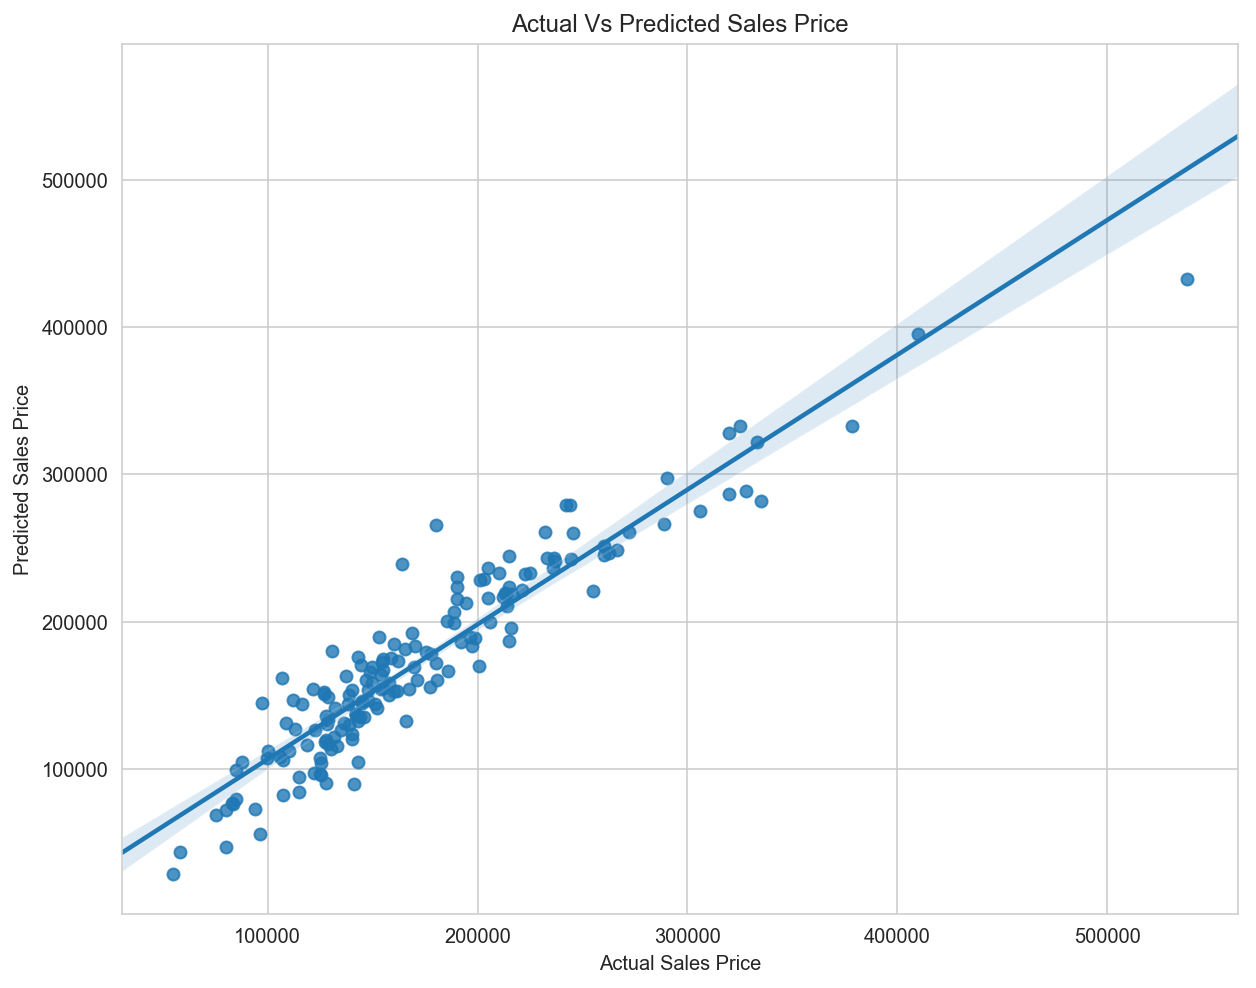

In [131]:
actual_vs_predicted_sales_price_df = pd.DataFrame()
actual_vs_predicted_sales_price_df['Actual Sales Price'] = y_test
actual_vs_predicted_sales_price_df['Predicted Sales Price'] = lscv_final.predict(X_test_final)
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
ax = sns.regplot(x='Actual Sales Price', y='Predicted Sales Price', data = actual_vs_predicted_sales_price_df,ax=ax)
ax.set_title("Actual Vs Predicted Sales Price");

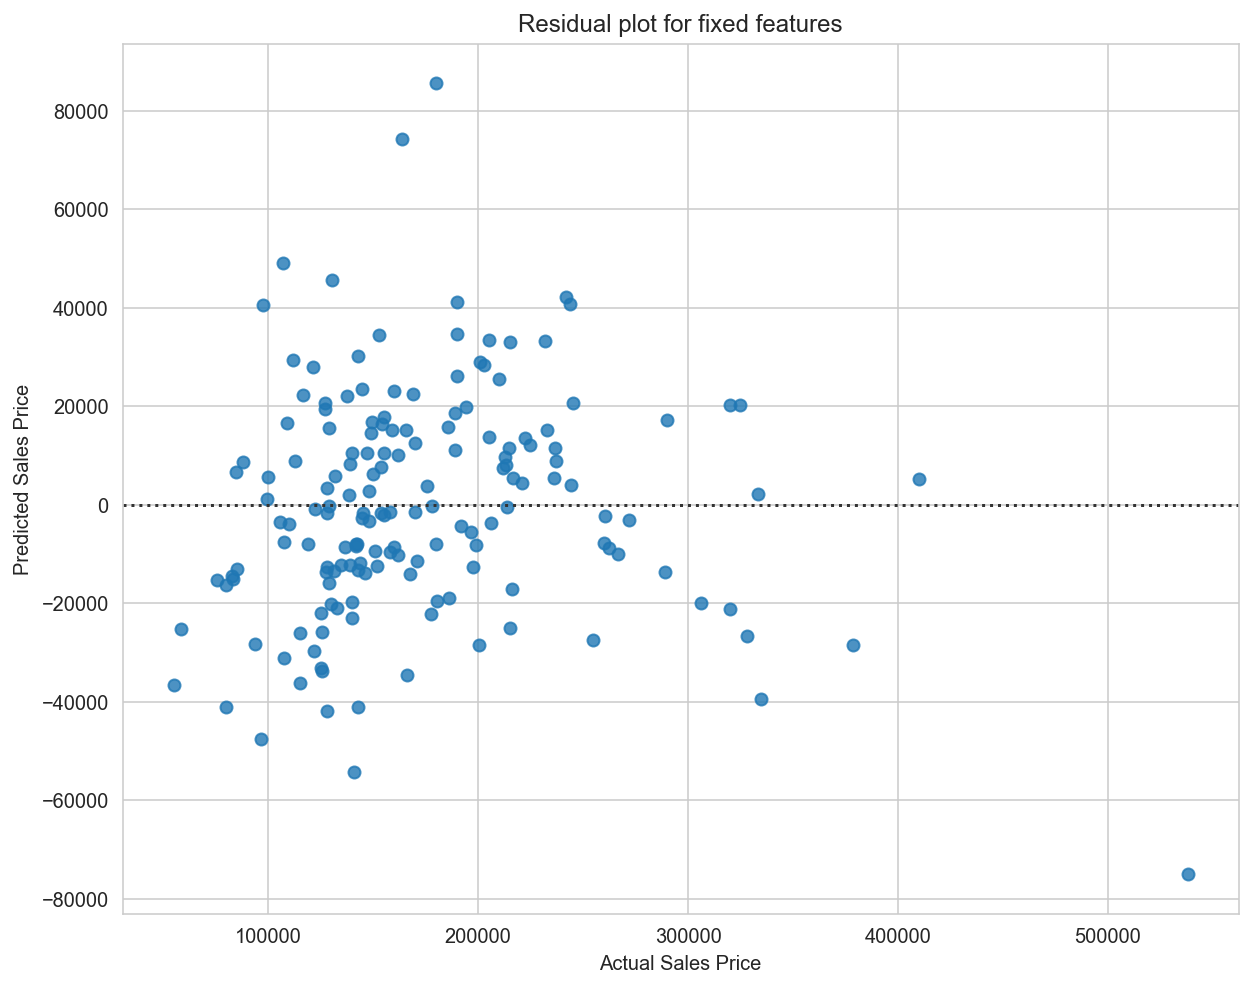

In [132]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
ax.set_title("Residual plot for fixed features");
sns.residplot(x= 'Actual Sales Price', y='Predicted Sales Price', data=actual_vs_predicted_sales_price_df,ax=ax);

In [133]:
train_final_pred = lscv_final.predict(X_train_final)
train_final_residuals = y_train - train_final_pred

In [134]:
test_final_pred = lscv_final.predict(X_test_final)
test_final_residuals =  y_test - test_final_pred

#### Evaluate the residuals from 1st and 2nd model

In [135]:

#test_fixed_pred = np.exp(test_fixed_pred) #Converting predicted values to saleprice

evaluation_dic = {
                    'Actual Sales price'                        : y_test,
                    'Fixed Predicted sales price'               : test_fixed_pred,
                    'Fixed and non-fixed predicted sales prices': test_final_pred,
                    'Fixed residuals'                           : test_fixed_residuals,
                    'Fixed non-fixed residuals'                 : test_final_residuals
}
evaluation_matrix = pd.DataFrame(evaluation_dic)
evaluation_matrix


,Actual Sales price,Fixed Predicted sales price,Fixed and non-fixed predicted sales prices,Fixed residuals,Fixed non-fixed residuals
16,149000,152852.671005,166329.281996,3852.671005,-17329.281996
24,154000,154646.834599,154465.289771,646.834599,-465.289771
26,134800,124595.214487,126391.372232,10204.785513,8408.627768
27,306000,274422.020385,275201.505583,31577.979615,30798.494417
33,165500,192030.914139,181833.438894,26530.914139,-16333.438894
38,109000,135383.216213,131757.241450,26383.216213,-22757.241450
45,319900,275534.977325,286663.558653,44365.022675,33236.441347
52,110000,96798.487762,112130.792647,13201.512238,-2130.792647
63,140000,134025.761533,153847.434460,5974.238467,-13847.434460
66,180000,263273.228779,265530.421973,83273.228779,-85530.421973


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

#### Tried and yet to finish

In [230]:
house_features_df_final = house_features_df[lasso_final_features]
house_features_df_final.shape
house_features_df_final['SaleCondition'] = house_new['SaleCondition']
house_features_df_final.shape

(1282, 37)

In [246]:
house_features_df_final[house_features_df_final['SaleCondition'] == 'Partial'].shape

(0, 37)

In [248]:

                                                  
house_features_df_final.drop(house_features_df_final[(house_features_df_final['SaleCondition']=='Partial') |
                          (house_features_df_final['SaleCondition']=='AdjLand')|
                          (house_features_df_final['SaleCondition']=='Alloca') |
                          (house_features_df_final['SaleCondition']=='Family')].index,inplace=True)

                                                  
house_features_df_final.shape

(1282, 37)

In [250]:
house_features_df_final['SaleCondition'].value_counts()

Normal     1188
Abnorml      94
Name: SaleCondition, dtype: int64

In [251]:
house_features_df_final['SaleCondition'] = house_features_df_final['SaleCondition'].map(lambda x: 1 if x == 'Normal' else 0)
house_features_df_final['SaleCondition'].value_counts()

1    1188
0      94
Name: SaleCondition, dtype: int64

In [252]:
predecitor_cols = [col for col in house_features_df_final.columns if col != 'SaleCondition']
X = house_features_df[predecitor_cols]
X.shape

(1282, 36)

In [253]:
y = house_features_df_final['SaleCondition']
y.shape

(1282,)

In [254]:
Xs = ss.fit_transform(X)

In [255]:
X_train,X_test,y_train,y_test = train_test_split(Xs,y,test_size=0.30)

In [256]:
X_train.shape, X_test.shape,y_train.shape,y_test.shape

((897, 36), (385, 36), (897,), (385,))

In [257]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
# lr_lasso = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=100, cv=10)
# lr_lasso.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [258]:
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)


In [259]:
conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['is_normal', 'is_abnormal'],
                         columns=['predicted_normal','predicted_abnormal'])
confusion

,predicted_normal,predicted_abnormal
is_normal,356,0
is_abnormal,29,0


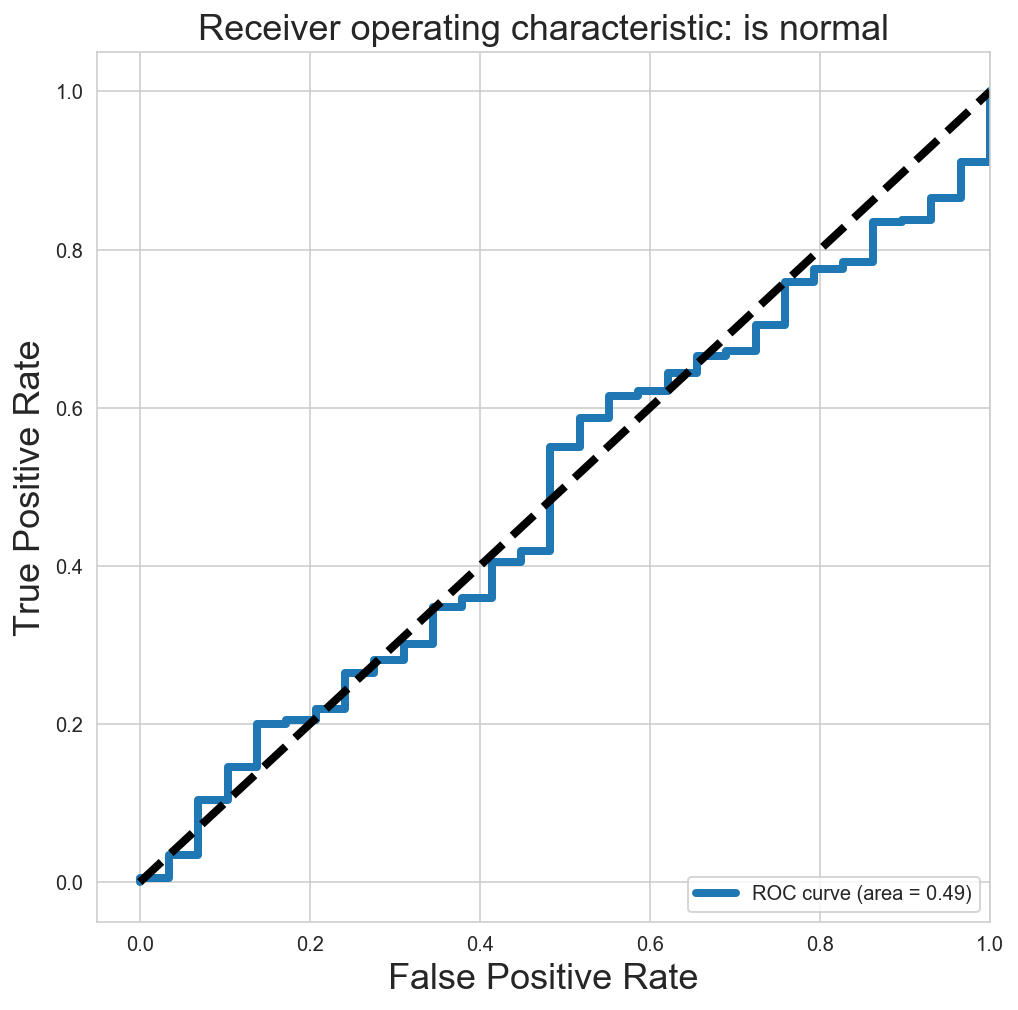

In [260]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is normal', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [261]:
from sklearn.linear_model import LogisticRegressionCV

In [262]:
lr_ridge = LogisticRegressionCV(penalty='l2', solver='liblinear')
lr_ridge.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='liblinear',
           tol=0.0001, verbose=0)

In [263]:
y_pred_ridge = lr_ridge.predict(X_test)
y_pred_proba_ridge = lr_ridge.predict_proba(X_test)


In [264]:
conmat = np.array(confusion_matrix(y_test, y_pred_ridge, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['is_normal', 'is_abnormal'],
                         columns=['predicted_normal','predicted_abnormal'])
confusion

,predicted_normal,predicted_abnormal
is_normal,356,0
is_abnormal,29,0


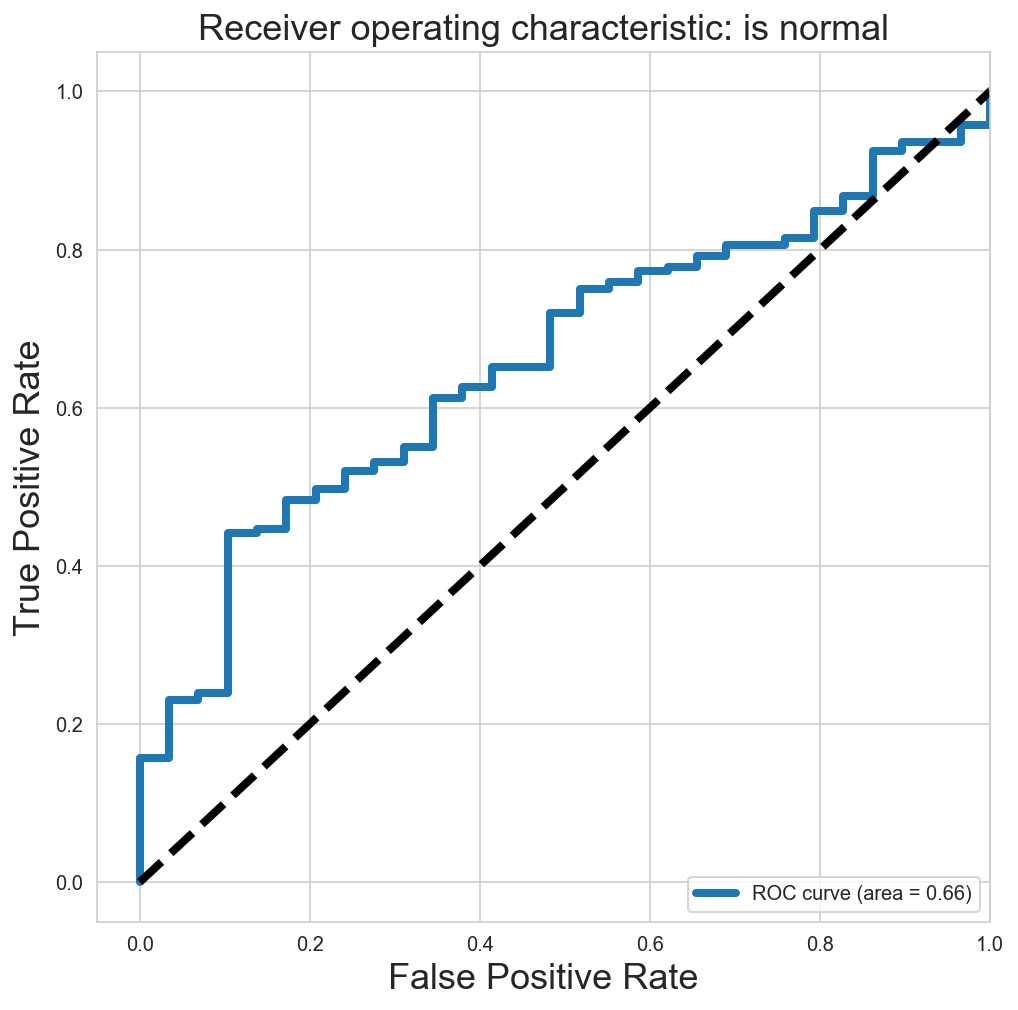

In [265]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_ridge[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is normal', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [284]:
coeffs = pd.DataFrame(lr_ridge.coef_, columns=X.columns)
coeffs_t = coeffs.transpose()
coeffs_t.columns = ['lasso_coefs']
coeffs_abs = coeffs_t.abs().sort_values('lasso_coefs', ascending=False)
coeffs_abs

,lasso_coefs
Fireplaces,0.016826
GarageArea,0.011353
TotalBsmtBath,0.010454
MSZoning_RL,0.010316
YearRemodAdd,0.009910
TotalPorchSF,0.008751
BsmtExposure_Gd,0.008750
HouseStyle_1.5Unf,0.008560
Exterior1st_CemntBd,0.008422
OverallCond,0.008026
